### Control Lab equipment remotely
* Sun EC13 temperature chamber
* CAEN N6724 digitizer
* CAEN N14171HV supply

In [1]:
# setup
import sys
CRANEPATH = '/opt/cranelab/CraneLab-build/'
CRANEPATH = '/home/achim/gaps/CraneLab/build'
if sys.path[-1] != CRANEPATH:
    sys.path.append(CRANEPATH)

import numpy as np
from skippylab.instruments.powersupplies import CAENN1471HV
from skippylab.instruments.climate_chambers import SunChamber
from skippylab.controllers import PrologixUsbGPIBController, ZMQController
from skippylab.controllers import SimpleSocketController
from skippylab.controllers import TelnetController

from skippylab.instruments.patchpannels import Cytec
import pyCaenN6725

Can not use adafruit dht sensors on this machine. Try installing requirements with pip3 install Adafruit_DHT


In [16]:
patchp = Cytec(TelnetController("192.168.1.7", 8081))

In [17]:
patchp.get_current_settings()
#patchp._controller.write(" ifconfig 192.168.1.7 255.255.255.0")

'F1\r\nA0, E0, V0\r\nBaudnumber = 6, RS Handshaking = 1\r\nGPIB = 7\r\nIP Address = 192.168.1.7\r\nNetmask = 255.255.255.0\r\nGateway = 0.0.0.0\r\nPort0 = 8080, Port1 = 8081\r\nTCP idle = 60\r\nTelnetlock = 0, Telnet Echo = 0\r\nBattery Ram = 0, Default List = 0\r\n0'

In [65]:
patchp.show_matrix()

['0000000000000000\r\n0000000000000000\r\n0000000000000000\r\n1111000000000000\r\n0000000000000000\r\n0000000000000000\r\n0000000000000000\r\n1111000000000000\r\n0']

In [64]:
patchp.latch_detector(0)

In [18]:
patchp.unlatch_all()

<CytecPatchPannelStatus.SUCCESS_OPEN: '0'>

### Operate the high voltage

In [4]:
# currently the hv is connected via USB
# (will change to e0ternet at some point)
HVPORT='/dev/ttyACM1'
HVPORT='/dev/serial/by-id/usb-CAEN_SPA_NIM_Desktop_HV_Power_Supply-if00'
#HVPORT = '/dev/usb/'
LOGLEVEL=30
try:
    hv = CAENN1471HV(port=HVPORT,
                                 loglevel=LOGLEVEL,
                                 time_delay=1.0)
except Exception as e:
    print(e)
    print ('Exception caught, try executing the cell again!')


In [6]:
# do something - activate the power

hv.channel0.voltage_as_set = 250
hv.channel0.current_as_set = 100.0 # 10 micro amps
hv.channel0.ramp_up = 3
hv.channel0.ramp_down = 3
hv.channel0.activate()


([5.0260227009421214,
  8.034370000008494,
  11.042597842984833,
  14.050985449925065,
  17.059877521009184,
  20.067867617006414,
  23.077131966943853,
  26.09375492099207,
  29.100900018005632,
  32.10897751094308,
  35.116949243005365,
  38.12522192695178,
  41.1335633599665,
  44.14357277995441,
  47.15174108103383,
  50.162194181000814,
  53.16782100498676,
  56.17838647402823,
  59.1877850079909,
  62.19976858992595,
  65.2112330510281,
  68.21983495994937,
  71.2278647290077,
  74.23522283695638,
  77.24368792097084,
  80.2518676680047,
  83.26119475392625,
  86.26943144598044,
  89.27711350400932,
  92.28520930197556,
  95.29028756800108,
  98.29891665303148,
  101.3059891370358,
  104.31352725799661,
  107.3182132820366,
  110.32609013596084,
  113.3323974260129,
  116.34169474698137,
  119.34876104502473,
  122.3582110350253,
  125.36620292195585,
  128.3742892629234,
  131.38219182693865,
  134.39102736697532,
  137.3991946859751,
  140.40763329796027,
  143.41580160101876,


In [12]:
# and deactivate
hv.channel0.ramp_down = 3
hv.channel0.deactivate()

KeyboardInterrupt: 

### Operate the SUN EC13 temperature chamber

In [2]:
import time
import numpy as np

SUNPORT = '/dev/ttyUSB1'
SUNPORT='/dev/serial/by-id/usb-Prologix_Prologix_GPIB-USB_Controller_PX30FLUZ-if00-port0'
sunec = SunChamber(PrologixUsbGPIBController(port=SUNPORT),
                                             publish=False,
                                             port=SUNPORT)

SUN EC13 chamber reporting status....
Power ON
Last command ok
Time out LED OFF
Not waiting for timeout
Heat output is disabled
Cool output is enabled
Valid set temperature
Deviation limit exceeded
Currently ramping
Chamber temp > lower limit
Chamber temp < upper limit
Not waiting at a BKPNT
Not in LP run mode
Not in LP remote store mode
Not in local edit LP mode
Not waiting to run LP as TOD
No GPIB bus timeout
Not in local keyboard lockout mode
System self test was ok
----------------------------------


In [4]:
sunec.get_temperature()

22.78

In [11]:
# power it on

sunec.ON
sunec.OFF

Turning on chamber...
Turning chamber off...


<IPython.core.display.Javascript object>


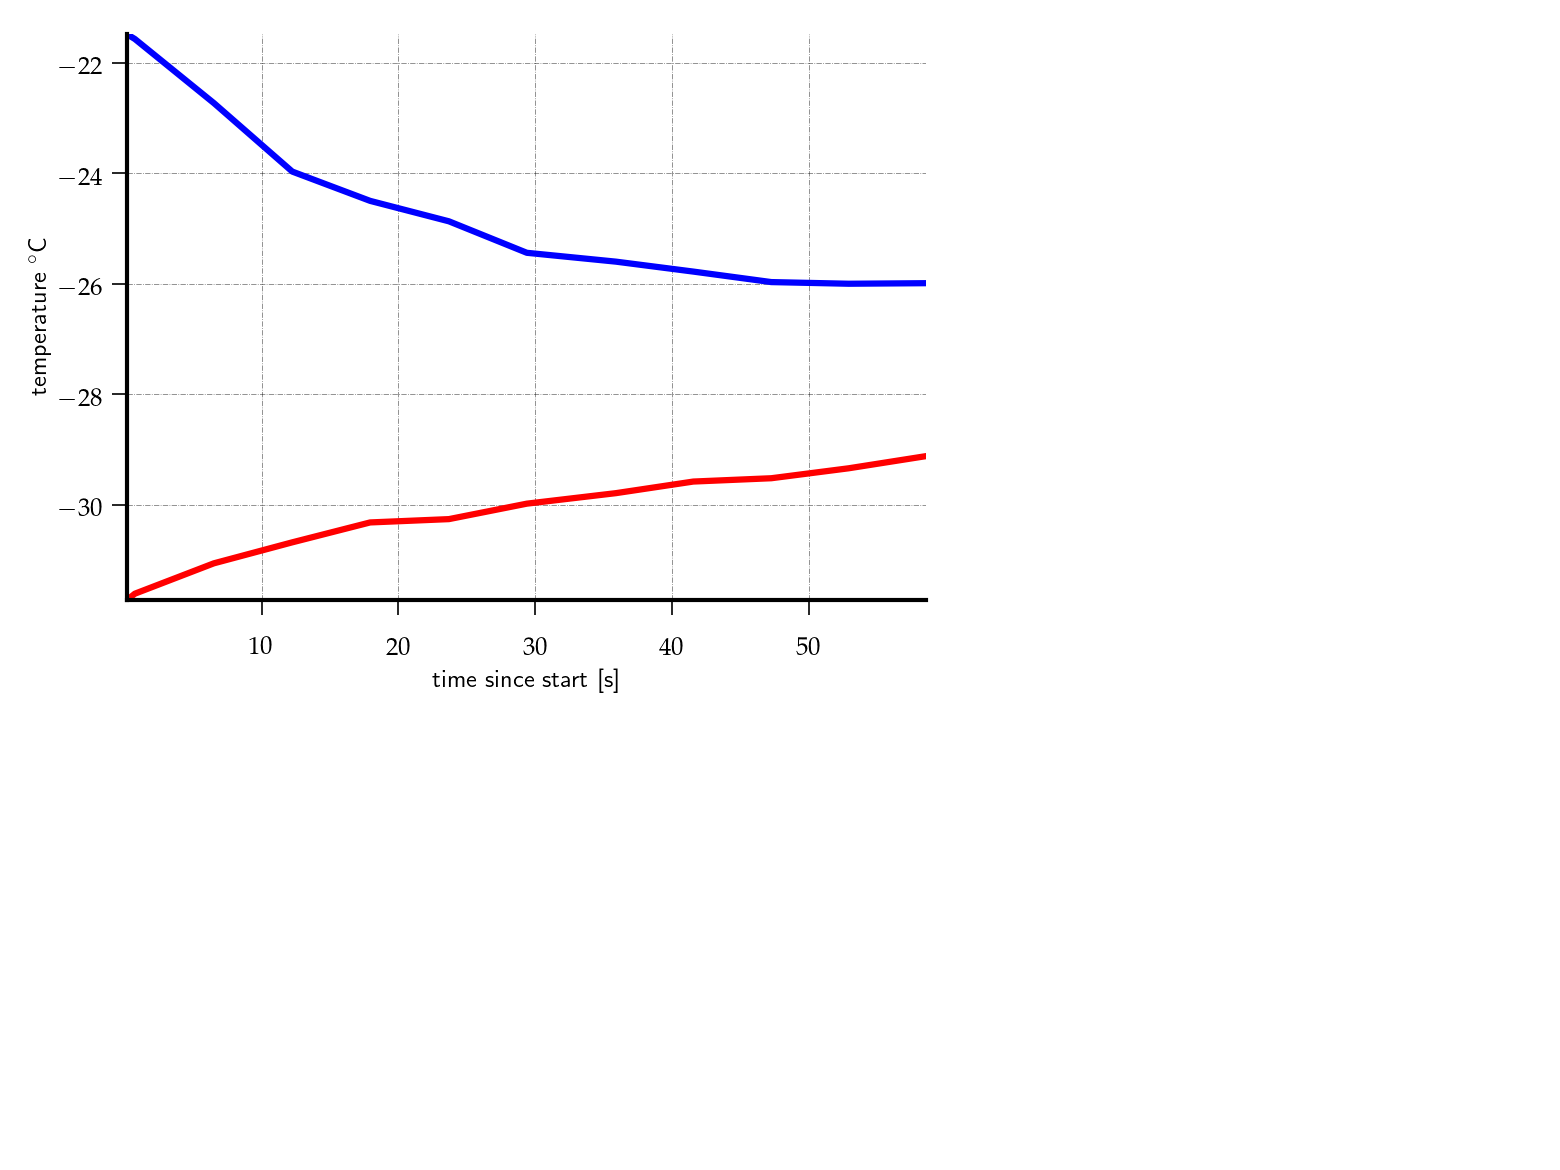

KeyboardInterrupt: 

In [10]:
%matplotlib notebook

#cooldown
sunec.ON
sunec.monitor_temperatures(target_temp=-47,
                           activate=True)
sunec.OFF

Turning on chamber...


<IPython.core.display.Javascript object>


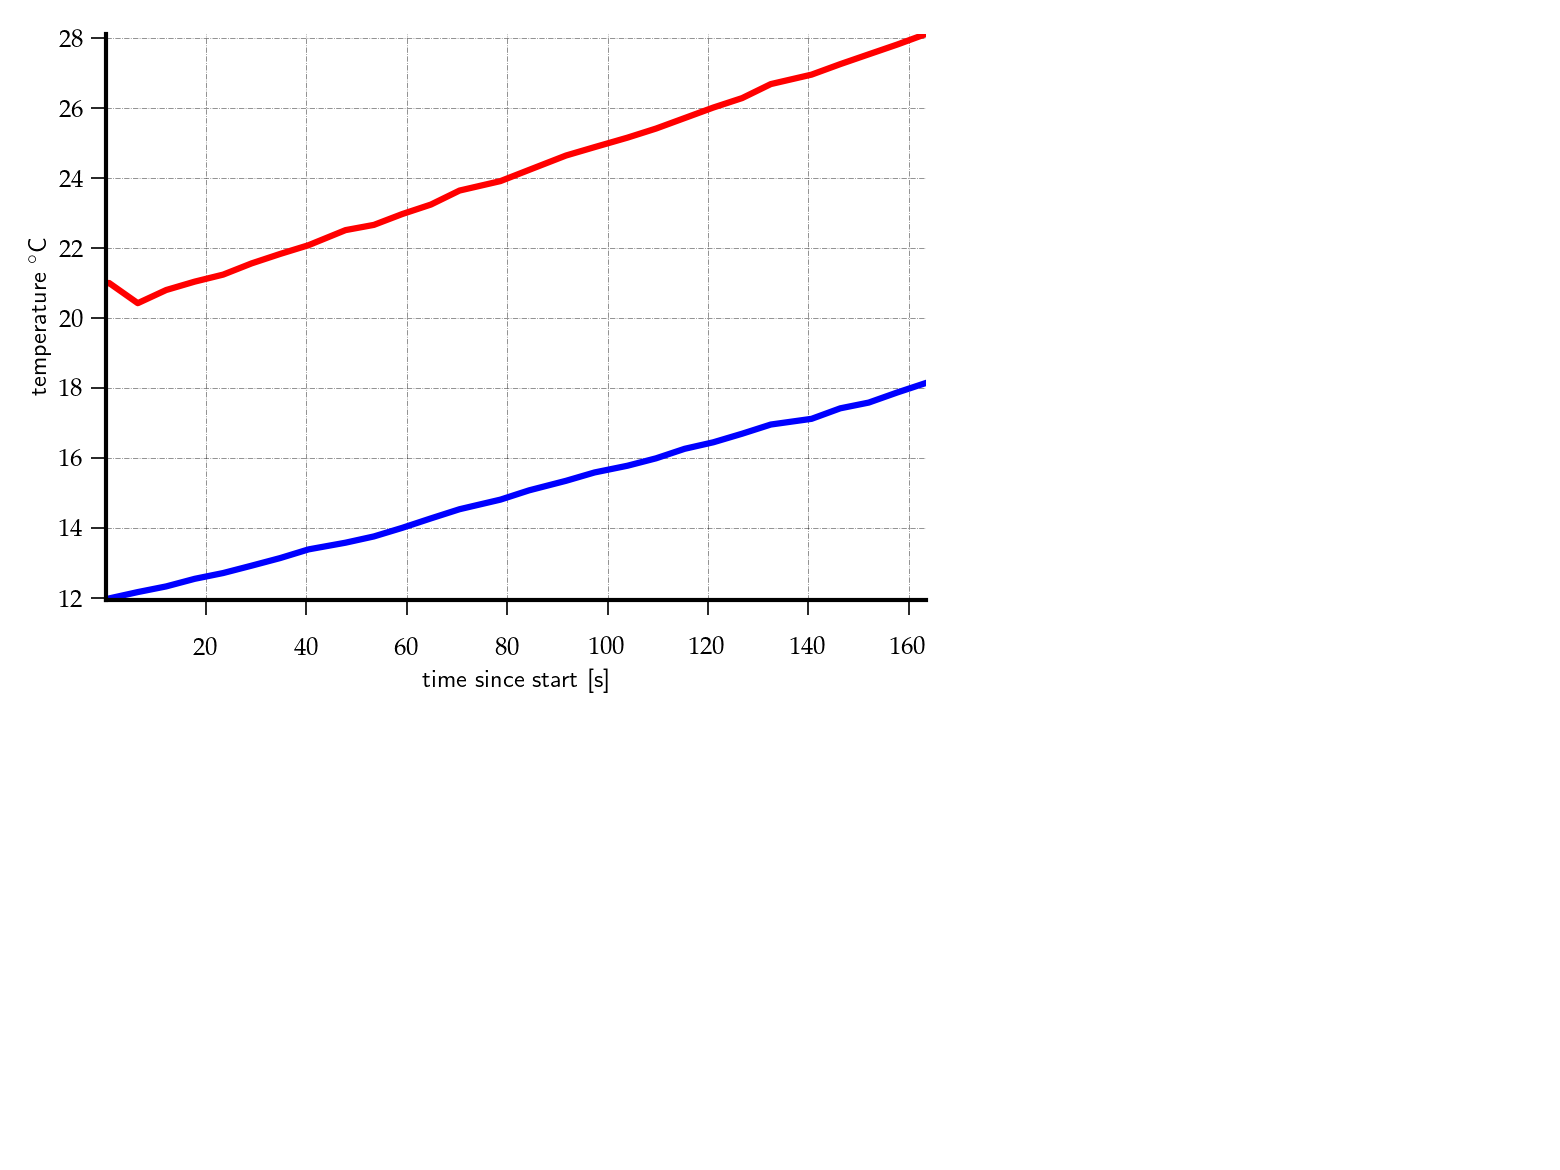

SerialException: write failed: [Errno 5] Input/output error

In [14]:
%matplotlib notebook

# warmup
sunec.ON
sunec.open_dry_nitrogen_valve()
sunec.monitor_temperatures(target_temp=30,
                           activate=True)
sunec.OFF

### Try the oscilloscope as a DAQ

In [ ]:
import skippylab.instruments.oscilloscopes as osc

rs = osc.RhodeSchwarzRTO1044('192.168.1.6')
print(rs.ping())
rs.instrument.ask("*IDN?")

In [ ]:
rs.active_channel

In [ ]:
rs.ACQUIRE_ONE

In [ ]:
rs.acquire_waveform?

In [ ]:
rs.do_single_acquisition?

In [ ]:
rs.acquire_waveform()

In [ ]:
origin = rs.instrument.ask('CHANnel1:DATA:XORigin?')
xincre = rs.instrument.ask('CHANnel1:DATA:XINC?')
print (origin)
print (xincre)
alldata = []

In [ ]:
import tqdm
import pickle

for k in range(50):
    #sunec.OFF
    alldata = []
    for i in range(100):
        print(k,i)
        rs.instrument.write("RUNSingle")
        rs.instrument.write('ACQuire:NSINgle:COUNt 1')
        #time.sleep(1)
        while(True):

            finished = rs.instrument.ask('ACQuire:STATe?')
            #print(finished)
            time.sleep(0.2)
            if (finished == "COMP"):
                data = rs.instrument.ask("CHAN1:DATA?")
                #print (data[:12])
                alldata.append(data)
                break
            #if (finished == "STOP"):
           #     print ('stopped')
           #     try:
           #         data = rs.instrument.ask("CHAN1:DATA?")
           #         print (data[:12])
           #         alldata.append(data)
           #         break
           #     except Exception as e:
           #         print (e)
           #         continue

    datatosave = dict()
    datatosave['xorig'] = origin
    datatosave['xincr'] = xincre
    datatosave['volts'] = alldata
    try:
        filetosavepi = open(f'/home/achim/xray{k}.pickle', "xb")
    except:
        filetosavepi = open(f'/home/achim/xrayA{k}.pickle', 'xb')
    pickle.dump(datatosave, filetosavepi)
    filetosavepi.close()
    
    #delta_t = 0
    #start = time.monotonic()
    #sunec.ON
    #temp = sunec.get_temperature()
    #while (not (np.isfinite(temp))):
    #    temp = sunec.get_temperature()
    #while temp > -42:
    #    print (temp)
    #    sunec.ON
    #    sunec.activate_cooler()
    #    sunec.deactivate_heater()

    #    sunec.rate_as_set = 3
    #    sunec.temperature_as_set = -45
    #    time.sleep(20)
    #    temp = sunec.get_temperature()
    #    while (not (np.isfinite(temp))):
    #        temp = sunec.get_temperature()
    #sunec.OFF

In [ ]:
temp

In [ ]:
print (len(alldata))
import pickle
import hjson

datatosave = dict()
datatosave['xorig'] = origin
datatosave['xincr'] = xincre
datatosave['volts'] = alldata
filetosavepi = open('/home/achim/firstmuons.pickle', "xb")
filetosavehj = open('/home/achim/firstmuons.json', 'w')
hjson.dump(datatosave, filetosavehj)
pickle.dump(datatosave, filetosavepi)
filetosavepi.close()
filetosavehj.close()

In [ ]:
file = open()

In [ ]:
data = rs.instrument.ask("CHAN1:DATA?")